# Rare Label Encoding

**Definition**
- Grouping rare labels (usually less than 5% of observations) into `Rare` label
- Create a dictionary of a list of frequent (non-rare) labels for each variable, and convert labels that are not in the list into `Rare` label.

**Benefit** 
- Rare labels can create overfitting as it does not have enough samples to provide generaliable information. Grouping rare labels into one group helps avoid overfitting. 
- It also helps handling of unseen labels when a model is in production.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/house_price/train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Fill NaN with 'missing'

In [4]:
df = df.fillna('missing')

# Split data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis=1), 
                                                    df['SalePrice'],
                                                   test_size=0.3,
                                                   random_state=0)

X_train.shape, X_test.shape

((1022, 80), (438, 80))

# Variables in different cardinality level 

In [6]:
# find variables with data type 'object', which means categorical
categorical_vars = X_train.dtypes[X_train.dtypes == 'O'].index
categorical_vars

Index(['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

## Variables with 2 categories (one dominant category)

In [7]:
# find variables there are only 2 or less categories and their frequencies

for col in categorical_vars: 
    if X_train[col].nunique() <= 2:
        print(X_train[col].value_counts()/len(X_train))
        print()

Pave    0.995108
Grvl    0.004892
Name: Street, dtype: float64

AllPub    0.999022
NoSeWa    0.000978
Name: Utilities, dtype: float64

Y    0.931507
N    0.068493
Name: CentralAir, dtype: float64



In the above example, the dominent variables from each variable (`Pave`, `AllPub`, and `Y`) composes more than 90% of the dataset. We can perform exploratory analysis to see if adding these three variables is useful. In not, we can drop the entire three columns.

## Variables with a few categories

In [8]:
for col in categorical_vars:
    n_unique = X_train[col].nunique()
    if n_unique > 2 and n_unique <5:
        print(X_train[col].value_counts()/len(X_train))
        print()

missing    0.939335
Pave       0.031311
Grvl       0.029354
Name: Alley, dtype: float64

Reg    0.628180
IR1    0.337573
IR2    0.028376
IR3    0.005871
Name: LotShape, dtype: float64

Lvl    0.903131
Bnk    0.043053
HLS    0.027397
Low    0.026419
Name: LandContour, dtype: float64

Gtl    0.941292
Mod    0.048924
Sev    0.009785
Name: LandSlope, dtype: float64

TA    0.626223
Gd    0.332681
Ex    0.029354
Fa    0.011742
Name: ExterQual, dtype: float64

TA    0.512720
Gd    0.392368
Ex    0.066536
Fa    0.028376
Name: KitchenQual, dtype: float64

Unf        0.408023
RFn        0.297456
Fin        0.241683
missing    0.052838
Name: GarageFinish, dtype: float64

Y    0.912916
N    0.069472
P    0.017613
Name: PavedDrive, dtype: float64

missing    0.997065
Gd         0.001957
Ex         0.000978
Name: PoolQC, dtype: float64

missing    0.956947
Shed       0.039139
Gar2       0.001957
Othr       0.001957
Name: MiscFeature, dtype: float64



There is almost always at least one infrequent category, meaning it composes less than 5% of the observations. 

When there is one dominent category and all other categories are infrequent (e.g. `Alley`), it might not be worth grouping them into a `Rare` category, as it will be then the same situation as the first case we saw (one dominent category and the other `Rare` category). In this case, we may want to perform an EDA to see if it is worth adding this variable or not. 

When there are at least two frequent categories and at least two infrequent categories (e.g. `LotShape`), it could be a good candidate to group infrequent categories into one `Rare` group.

## Variables with high cardinality

In [9]:
# variables with more than 10 categories. Print the top 10 categories for each variable 
for col in categorical_vars:
    if X_train[col].nunique() >10:
        print(f"{col}: {X_train[col].nunique()} labels")
        print((X_train[col].value_counts()/len(X_train)).head(10))
        print()

LotFrontage: 102 labels
missing    0.184932
60.0       0.091977
80.0       0.054795
50.0       0.040117
70.0       0.035225
75.0       0.035225
85.0       0.028376
65.0       0.025440
90.0       0.017613
78.0       0.017613
Name: LotFrontage, dtype: float64

Neighborhood: 25 labels
NAmes      0.147750
CollgCr    0.102740
OldTown    0.071429
Edwards    0.069472
Sawyer     0.059687
Somerst    0.054795
Gilbert    0.053816
NWAmes     0.049902
NridgHt    0.049902
SawyerW    0.044031
Name: Neighborhood, dtype: float64

Exterior1st: 15 labels
VinylSd    0.356164
HdBoard    0.149706
Wd Sdng    0.144814
MetalSd    0.135029
Plywood    0.084149
CemntBd    0.038160
BrkFace    0.034247
WdShing    0.020548
Stucco     0.016634
AsbShng    0.014677
Name: Exterior1st, dtype: float64

Exterior2nd: 16 labels
VinylSd    0.345401
Wd Sdng    0.138943
HdBoard    0.137965
MetalSd    0.133072
Plywood    0.109589
CmentBd    0.038160
Wd Shng    0.028376
BrkFace    0.017613
AsbShng    0.016634
Stucco     0.015656


LotFrontage: 102 labels


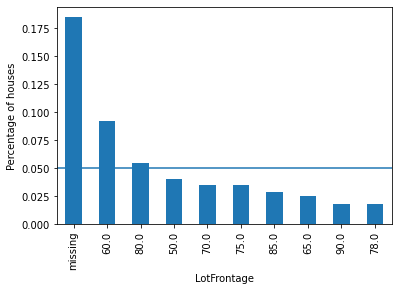

Neighborhood: 25 labels


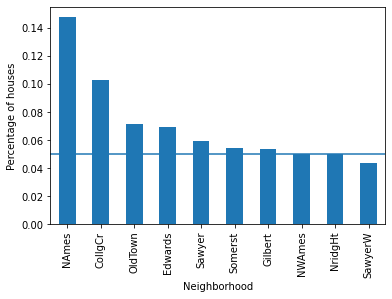

Exterior1st: 15 labels


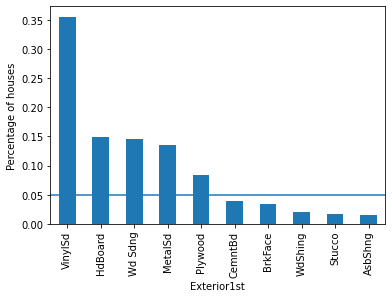

Exterior2nd: 16 labels


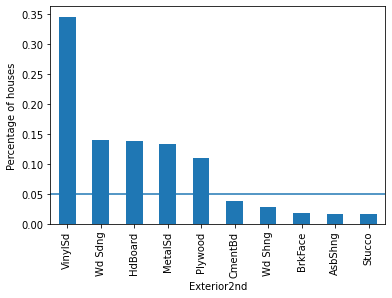

MasVnrArea: 262 labels


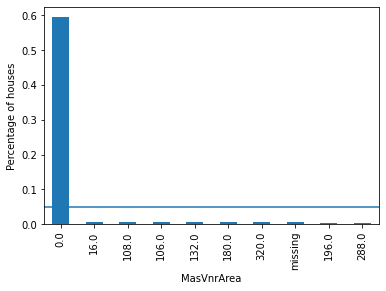

GarageYrBlt: 95 labels


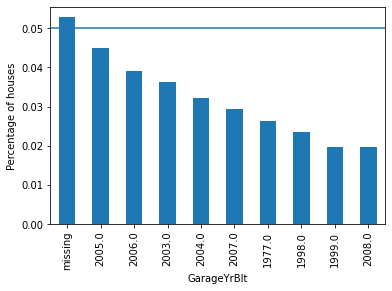

In [10]:
for col in categorical_vars:
    if X_train[col].nunique() >10:
        print(f"{col}: {X_train[col].nunique()} labels")
        fig, ax = plt.subplots()
        temp = (X_train[col].value_counts()/len(X_train)).head(10)
        temp.plot.bar()
        plt.xlabel(col)
        plt.ylabel('Percentage of houses')

        # horizontal line 
        plt.axhline(y=0.05)
        plt.show()
        

Most of them, except for `MasVnrArea` and `GarageYrBlt`, have at least a few frequent categories. They would be good candidates for rare category grouping.

# Grouping rare labels

In [11]:
# find frequent (non-rare) labels 
def find_non_rare_labels(df, variable, tolerance):
    temp = df[variable].value_counts()/len(df)
    non_rare = list(temp[temp > tolerance].index.values)
    return non_rare 

# encoding
non_rare_dict = {}
for col in categorical_vars:
    non_rare = find_non_rare_labels(X_train, col, tolerance=0.05)
    non_rare_dict[col] = non_rare

In [12]:
non_rare_dict

{'MSZoning': ['RL', 'RM'],
 'LotFrontage': ['missing', 60.0, 80.0],
 'Street': ['Pave'],
 'Alley': ['missing'],
 'LotShape': ['Reg', 'IR1'],
 'LandContour': ['Lvl'],
 'Utilities': ['AllPub'],
 'LotConfig': ['Inside', 'Corner', 'CulDSac'],
 'LandSlope': ['Gtl'],
 'Neighborhood': ['NAmes',
  'CollgCr',
  'OldTown',
  'Edwards',
  'Sawyer',
  'Somerst',
  'Gilbert'],
 'Condition1': ['Norm'],
 'Condition2': ['Norm'],
 'BldgType': ['1Fam', 'TwnhsE'],
 'HouseStyle': ['1Story', '2Story', '1.5Fin'],
 'RoofStyle': ['Gable', 'Hip'],
 'RoofMatl': ['CompShg'],
 'Exterior1st': ['VinylSd', 'HdBoard', 'Wd Sdng', 'MetalSd', 'Plywood'],
 'Exterior2nd': ['VinylSd', 'Wd Sdng', 'HdBoard', 'MetalSd', 'Plywood'],
 'MasVnrType': ['None', 'BrkFace', 'Stone'],
 'MasVnrArea': [0.0],
 'ExterQual': ['TA', 'Gd'],
 'ExterCond': ['TA', 'Gd'],
 'Foundation': ['PConc', 'CBlock', 'BrkTil'],
 'BsmtQual': ['TA', 'Gd', 'Ex'],
 'BsmtCond': ['TA'],
 'BsmtExposure': ['No', 'Av', 'Gd', 'Mn'],
 'BsmtFinType1': ['Unf', 'GLQ', '

In [13]:
# replacing 
def replace_with_rare(df, col, non_rare):
    return np.where(df[col].isin(non_rare), df[col], 'Rare')

# replacing 
for col in categorical_vars:
    X_train[col] = replace_with_rare(X_train, col, non_rare_dict[col])


In [14]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
64,65,60,RL,missing,9375,Pave,missing,Reg,Lvl,AllPub,...,0,0,missing,Rare,missing,0,2,2009,WD,Normal
682,683,120,RL,missing,2887,Pave,missing,Reg,Rare,AllPub,...,0,0,missing,missing,missing,0,11,2008,WD,Normal
960,961,20,RL,Rare,7207,Pave,missing,IR1,Lvl,AllPub,...,0,0,missing,missing,missing,0,2,2010,WD,Normal
1384,1385,50,RL,60,9060,Pave,missing,Reg,Lvl,AllPub,...,0,0,missing,MnPrv,missing,0,10,2009,WD,Normal
1100,1101,30,RL,60,8400,Pave,missing,Reg,Rare,AllPub,...,0,0,missing,missing,missing,0,1,2009,WD,Normal


MSZoning: 3 labels


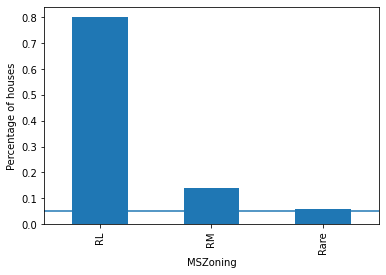

LotFrontage: 4 labels


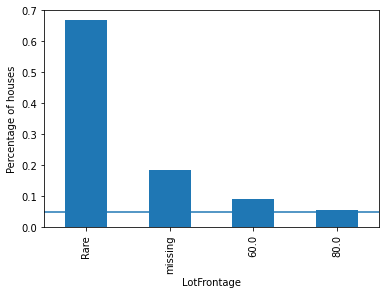

Street: 2 labels


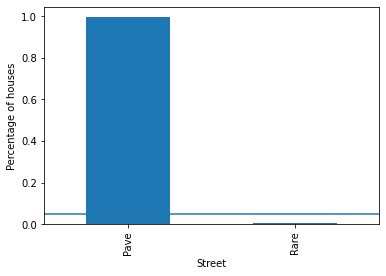

Alley: 2 labels


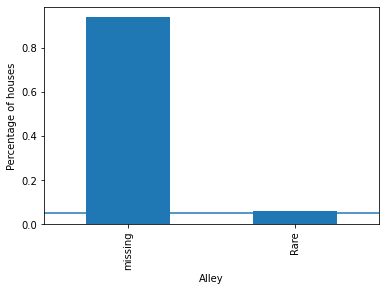

LotShape: 3 labels


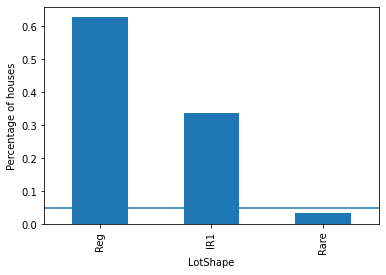

LandContour: 2 labels


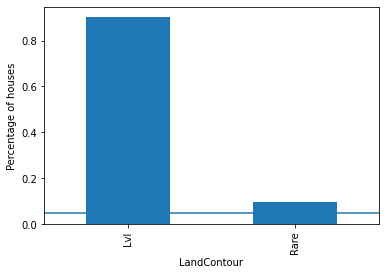

Utilities: 2 labels


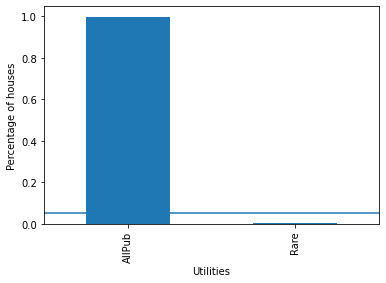

LotConfig: 4 labels


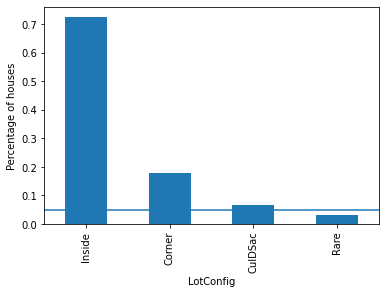

LandSlope: 2 labels


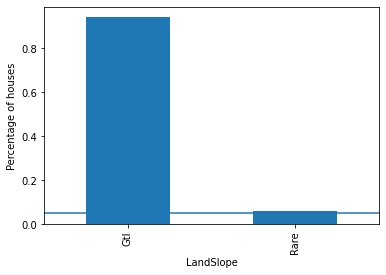

Neighborhood: 8 labels


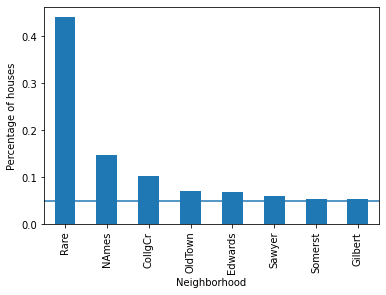

In [15]:
for col in categorical_vars[:10]:
    print(f"{col}: {X_train[col].nunique()} labels")
    fig, ax = plt.subplots()
    temp = (X_train[col].value_counts()/len(X_train)).head(10)
    temp.plot.bar()
    plt.xlabel(col)
    plt.ylabel('Percentage of houses')

    # horizontal line 
    plt.axhline(y=0.05)
    plt.show()
        